In [1]:
%matplotlib widget
import os
os.environ["GDAL_DATA"] = "/srv/conda/envs/notebook/share/gdal" # need to specify to make gdal work
os.environ["PROJ_LIB"] = "/srv/conda/envs/notebook/share/proj" # need to specify to make pyproj work
os.environ["PROJ_DATA"] = "/srv/conda/envs/notebook/share/proj" # need to specify to make pyproj work
import numpy as np
import pandas as pd
from matplotlib import cm 
import matplotlib
import matplotlib.pylab as plt
import geopandas as gpd
from ipyleaflet import Map, basemaps, Polygon, Polyline, GeoData, LayersControl
from datetime import datetime
from dateutil.relativedelta import relativedelta

from utils.nsidc import download_is2
from utils.readers import read_atl06
from ed.edcreds import getedcreds

## Show area of interest on a map

In [2]:
# I just drew these randomly on a map...
shape = 'data/shapefiles/petermann_marginal_lake.geojson'
lake_small = 'data/shapefiles/petermann-small-lake.geojson'
shape_buffer = 'data/shapefiles/petermann_marginal_lake_buffer.geojson'

gdf = gpd.read_file(shape_buffer)
geom = [i for i in gdf.geometry]
lons,lats = geom[0].exterior.coords.xy
shape_buffer_coords = list(zip(lats,lons))
gdf = gpd.read_file(shape)
geom = [i for i in gdf.geometry]
lons,lats = geom[0].exterior.coords.xy
shape_coords = list(zip(lats,lons))
shape_bounds = [[np.min(lats),np.min(lons)], [np.max(lats),np.max(lons)]]
gdf = gpd.read_file(lake_small)
geom = [i for i in gdf.geometry]
lons,lats = geom[0].exterior.coords.xy
shape_small_lake_coords = list(zip(lats,lons))

m=Map(basemap=basemaps.Esri.WorldImagery,center=[np.mean(lats),np.mean(lons)],zoom=9)
m.fit_bounds(shape_bounds)
polygon = Polygon(locations=shape_buffer_coords, color="green", fill_color="blue", name='polygon_buffered')
m.add_layer(polygon)
polygon2 = Polygon(locations=shape_coords, color="blue", fill_color="blue", name='polygon')
m.add_layer(polygon2)
polygon3 = Polygon(locations=shape_small_lake_coords, color="red", fill_color="red", name='polygon')
m.add_layer(polygon3)
m.add_control(LayersControl())
m

Map(center=[80.28435967005717, -59.58383610097026], controls=(ZoomControl(options=['position', 'zoom_in_text',…

### Download the ICESat-2 data over this area

In [3]:
# this is just to get the earthdata credits into the notebook without pushing them to github
# can just specify them directly here like below
# uid = 'insert_your_earthdata_user_id_here'
# pwd = 'insert_your_earthdata_password_here'
uid, pwd, email = getedcreds()

# to set up the getedcreds() function:
# - create a folder called "ed"
# - in this folder, create an empty file called "__init__.py"
# - in this folder, creat a file called "edcreds.py", with the following function:
#   def getedcreds(): return '<your_earthdata_user_id>', '<your_earthdata_password>', '<your_email_address>'
# - if you push to github, make sure to include the folder ed/ in your .gitignore

### Data download 201 response error fix: loop through dates in 6-month increments

In [4]:
re_download_data = False

if re_download_data:

    # could change the version to 6 here, but there's more release 005 data so far
    version = 5

    start_download_date = '2018-06-30'
    short_name = 'ATL06'
    output_dir='data/IS2/v%03i' % version
    increment_months = 6

    dateformat = '%Y-%m-%d'
    end_download_datetime = datetime.strptime(start_download_date, dateformat)
    while end_download_datetime < datetime.now():
        start_download_datetime = end_download_datetime + relativedelta(days=1)
        end_download_datetime = start_download_datetime + relativedelta(months=increment_months)
        start_date = datetime.strftime(start_download_datetime, dateformat)
        end_date = datetime.strftime(end_download_datetime, dateformat)
        print('\n______________________________________________________________________\n')
        print('downloading data: %s  --->  %s' % (start_date, end_date))
        download_is2(short_name=short_name, 
                 start_date=start_date, 
                 end_date=end_date, 
                 uid=uid, 
                 pwd=pwd, 
                 shape=shape_buffer, 
                 output_dir=output_dir,
                 version=version)

In [5]:
# # if you want ATL03 data, you could run the code below
# download_is2(short_name='ATL03', 
#              start_date='2018-01-01', 
#              end_date='2030-01-01', 
#              uid=uid, 
#              pwd=pwd, 
#              shape=shape_buffer, 
#              output_dir='data/IS2')

### Get a list of all the ATL06 data files over this region

In [6]:
search_for = 'ATL06_'
search_in = 'data/IS2/v005/'
filelist = [search_in+f for f in os.listdir(search_in) \
            if os.path.isfile(os.path.join(search_in, f)) & (search_for in f) & ('.h5' in f)]
# filelist.sort()
print('There are %i files.' % len(filelist))

There are 166 files.


### Just pick the first file, and plot the ground tracks on the map

In [7]:
file = filelist[0]
ancillary, dfs = read_atl06(file, verbose=False)
for gtx in dfs.keys():
    dfs[gtx] = dfs[gtx][dfs[gtx].qual_summary == 0]

### Some helpful ancillary data for an example ICESat-2 track

In [8]:
ancillary

{'granule_id': 'ATL06_20211231104501_01401404_005_01.h5',
 'date': '2021-12-31',
 'atlas_sdp_gps_epoch': 1198800018.0,
 'rgt': 140,
 'cycle_number': 14,
 'sc_orient': 'backward',
 'gtx_beam_dict': {'gt1l': 1,
  'gt1r': 2,
  'gt2l': 3,
  'gt2r': 4,
  'gt3l': 5,
  'gt3r': 6},
 'gtx_strength_dict': {'gt1l': 'strong',
  'gt1r': 'weak',
  'gt2l': 'strong',
  'gt2r': 'weak',
  'gt3l': 'strong',
  'gt3r': 'weak'}}

### an example dataframe with ATL06 data

In [9]:
dfs[list(dfs.keys())[0]]

,delta_time,lat,lon,xatc,h,geoid_h,qual_summary
0,1.261827e+08,80.146650,-60.198991,8.955899e+06,509.523499,18.512732,0
1,1.261827e+08,80.146826,-60.199206,8.955919e+06,511.870148,18.511702,0
2,1.261827e+08,80.147001,-60.199423,8.955939e+06,511.911346,18.510647,0
3,1.261827e+08,80.147176,-60.199641,8.955959e+06,510.970428,18.509584,0
4,1.261827e+08,80.147352,-60.199861,8.955979e+06,511.925568,18.508522,0
...,...,...,...,...,...,...,...
704,1.261827e+08,80.269770,-60.360632,8.969984e+06,416.770691,17.808111,0
705,1.261827e+08,80.269945,-60.360871,8.970004e+06,416.864960,17.807125,0
706,1.261827e+08,80.270120,-60.361108,8.970024e+06,416.729431,17.806145,0
707,1.261827e+08,80.270294,-60.361342,8.970044e+06,415.763245,17.805147,0


### show a few tracks on a map to get an idea of coverage

In [10]:
m=Map(basemap=basemaps.Esri.WorldImagery,center=[np.mean(lats),np.mean(lons)],zoom=9)
m.fit_bounds(shape_bounds)

# plot the first 15 tracks
nfiles = 50
filelist.sort()
for file in filelist[:nfiles]:
    ancillary, dfs = read_atl06(file, verbose=False)
    for gtx in dfs.keys():
        dfs[gtx] = dfs[gtx][dfs[gtx].qual_summary == 0]
        dfs[gtx].lat, dfs[gtx].lon
        coords = list(zip(dfs[gtx].lat, dfs[gtx].lon))
        weight = 2 if ancillary['gtx_strength_dict'][gtx] == 'strong' else 1
        name = 'track %d-%s' % (ancillary['rgt'], gtx)
        line = Polyline(locations=coords,color="red",weight=weight,fill=False, name=name)
        m.add_layer(line)

polygon = Polygon(locations=shape_coords, color="blue", fill_color="blue", name='polygon')
m.add_layer(polygon)

m.add_control(LayersControl())
m

Map(center=[80.28435967005717, -59.58383610097026], controls=(ZoomControl(options=['position', 'zoom_in_text',…

### inspect some of the data

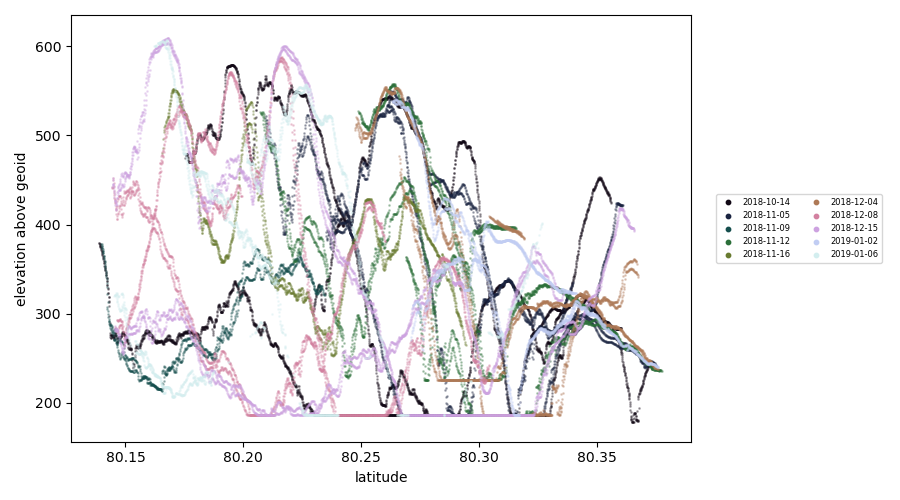

In [11]:
fig, ax = plt.subplots(figsize=[9, 5], dpi=100)
handles = []

# plot the first few files
nfiles = 10
colors = cm.cubehelix(np.linspace(0.05,0.9,nfiles))
for i, file in enumerate(filelist[:nfiles]):
    ancillary, dfs = read_atl06(file, verbose=False)
    df = pd.concat(dfs)
    df = df[df.qual_summary == 0].copy()
    df['h_geoid_corrected'] = df.h - df.geoid_h
    df = df[np.abs(df.h_geoid_corrected) < 1e5]
    ax.scatter(df.lat, df.h_geoid_corrected , s=1, alpha=0.3, color=tuple(colors[i,:]))
    scatt = ax.scatter(0, 0 , s=10, alpha=1, color=tuple(colors[i,:]), label=ancillary['date'])
    handles.append(scatt)
# ax.legend(loc='upper right')
plt.legend(handles=handles, bbox_to_anchor=(1.04, 0.5), loc="center left", borderaxespad=0, fontsize=6, ncols=2)
ax.set_xlim((80.12685987765869, 80.38980029579673))
ax.set_ylim((156.4133674621582, 634.9853904724121))
ax.set_xlabel('latitude')
ax.set_ylabel('elevation above geoid')
fig.tight_layout()

### get the lake elevation for each file 

In [12]:
smoothing_length = 0.5  # length over which to smooth histogram in meters
min_elev = 130  # minimum elevation to consider in meters
max_elev = 280  # maximum elevation to consider in meters
dh = 0.01  # histogram bin spacing in meters

def lake_elev_time_series(lake_shape, files_directory):
    
    nfiles = None # put None to run for all files

    # make the list of all files to process
    search_for = 'ATL06_'
    search_in = files_directory
    filelist = [search_in+f for f in os.listdir(search_in) \
                if os.path.isfile(os.path.join(search_in, f)) & (search_for in f) & ('.h5' in f)]
    filelist.sort()

    gdf_lake = gpd.read_file(lake_shape)  # turn geojson shape into a georeferenced dataframe
    hist_bins = np.arange(min_elev, max_elev+dh, dh)
    hist_mids = hist_bins[:-1] + np.diff(hist_bins) / 2

    files_to_process = filelist[:nfiles]  # clip the filelist to the nfiles first entries
    date_list, elev_list, count_list = [], [], []  # initialize the output lists

    # loop through all the files
    for i, file in enumerate(files_to_process):

        # read the file
        ancillary, dfs = read_atl06(file, verbose=False)

        # get the date of the file
        this_date = datetime.strptime(ancillary['date'], '%Y-%m-%d')
        if len(dfs) > 0:  # make sure there is some data
            df = pd.concat(dfs,ignore_index=True)  # just throw all the beams together for this purpose
            df = df[df.qual_summary == 0].copy()  # take only data that passes the quality summary
            df['h_geoid_corrected'] = df.h - df.geoid_h  # correct surface heights for geoid elevation
            df = df[np.abs(df.h_geoid_corrected) < 1e5]  # remove weird large nodata values

            # turn this into a georeferenced dataframe and clip to the actual lake outline (at least roughly...)
            gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon, df.lat), crs="EPSG:4326")  
            gdf = gpd.clip(gdf, gdf_lake)

            # make a histogram of data point counts vs. elevations at get the elevation where most data falls
            counts, bins = np.histogram(gdf.h_geoid_corrected, bins=hist_bins)  # make the histogram
            window_size = int(np.ceil(smoothing_length/dh))  # get the window size for smoothing
            counts = pd.Series(counts).rolling(window=window_size, center=True).sum()  # smooth the data a bit (sum of counts over smoothing_length)
            max_counts = np.max(counts)  # how many counts do we get?

            # only use data with 5 points in a smoothing_length elevation window to make this more robust
            if max_counts > 10: 
                max_idx = np.argmax(counts)  # get the index of the histogram peak
                this_elev = hist_mids[max_idx]  # get the elevation where most data is found

                # append the results to the output lists
                date_list.append(this_date)
                elev_list.append(this_elev)
                count_list.append(max_counts)

        print('%i / %i files processed' % (i+1, len(files_to_process)), end='\r')
        
    results = pd.DataFrame({'date': date_list, 'elev': elev_list, 'counts': count_list})
    
    return results

### put the results together and plot

In [13]:
lake_shape_main = 'data/shapefiles/petermann_marginal_lake.geojson'
lake_shape_small = 'data/shapefiles/petermann-small-lake.geojson'
files_directory = 'data/IS2/v005/'

results_main = lake_elev_time_series(lake_shape_main, files_directory)
results_small = lake_elev_time_series(lake_shape_small, files_directory)

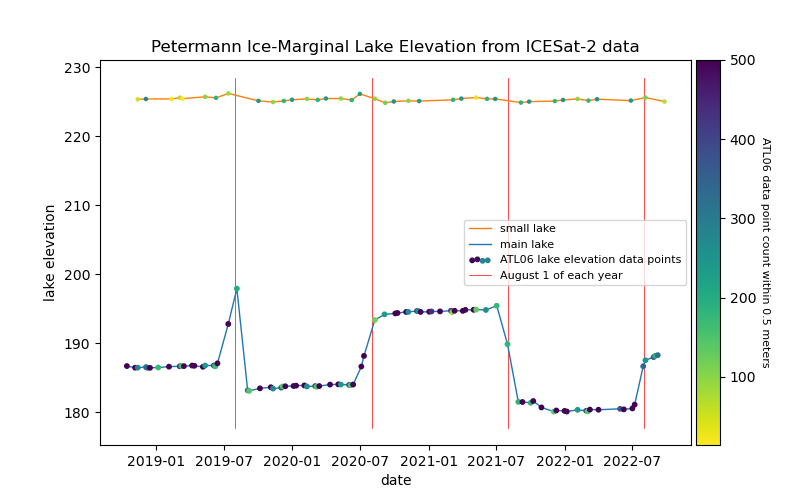

In [14]:
results_main = results_main[results_main.counts > 50]

fig, ax = plt.subplots(figsize=[8,5], dpi=100)

small_line, = ax.plot(results_small.date, results_small.elev, c='C1', lw=1, zorder=-1000, label='small lake')
main_line, = ax.plot(results_main.date, results_main.elev, c='C0', lw=1, zorder=-1000, label='main lake')

scatterplot = ax.scatter(results_main.date, results_main.elev, s=10, alpha=1, c=results_main.counts, cmap=cm.viridis_r, 
                   vmin=np.min(results_small.counts), vmax=500, zorder=1000, label='ATL06 lake elevation data points')
ax.scatter(results_small.date, results_small.elev, s=5, alpha=1, c=results_small.counts, cmap=cm.viridis_r, 
                   vmin=np.min(results_small.counts), vmax=500, zorder=1000, label='ATL06 lake elevation data points')

augusts = [datetime(2019, 8, 1) + relativedelta(years=i) for i in np.arange(4)]
yl = ax.get_ylim()
for aug1 in augusts:
    august_line, = ax.plot([aug1]*2, yl, 'r-', lw=0.5, label='August 1 of each year', zorder=-10000)

ax.set_xlabel('date')
ax.set_ylabel('lake elevation')
ax.set_title('Petermann Ice-Marginal Lake Elevation from ICESat-2 data')

# make colorbar
from mpl_toolkits.axes_grid1 import make_axes_locatable
# add the colorbar 
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='4%', pad=0.05)
cbar = fig.colorbar(scatterplot, cax=cax, orientation='vertical')
cbar.ax.get_yaxis().labelpad = 10
cbar.ax.set_ylabel('ATL06 data point count within %g meters' % smoothing_length, rotation=270, fontsize=8)

ax.legend(handles=[small_line, main_line, scatterplot, august_line], loc='right', fontsize=8, scatterpoints=4)